In [1]:
# Load the required packages

import pandas as pd
import numpy as np 
import re

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import BernoulliNB
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import plot_precision_recall_curve

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# import the feature_extract file to perform feature extraction process
%run feature_extraction.py
from feature_extraction import FeatureExtract, PredictURL

import pickle

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


import timeit
from math import sqrt

In [2]:
!pip install lxml

## Loading the phishing dataset

In [3]:
#Load the dataset into dataframe

phishing_raw_df = pd.read_csv("Main_dataset.csv", header = 0)

In [4]:
# Dropping null values, duplicates and reset the index

phishing_raw_df = phishing_raw_df.dropna()
phishing_raw_df = phishing_raw_df.drop_duplicates()
phishing_raw_df = phishing_raw_df.reset_index(drop=True)
phishing_raw_df.shape

(72363, 12)

In [5]:
print(phishing_raw_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72363 entries, 0 to 72362
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   domain          72363 non-null  object
 1   ranking         72363 non-null  int64 
 2   isIp            72363 non-null  int64 
 3   valid           72363 non-null  int64 
 4   activeDuration  72363 non-null  int64 
 5   urlLen          72363 non-null  int64 
 6   is@             72363 non-null  int64 
 7   isredirect      72363 non-null  int64 
 8   haveDash        72363 non-null  int64 
 9   domainLen       72363 non-null  int64 
 10  nosOfSubdomain  72363 non-null  int64 
 11  label           72363 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.6+ MB
None


## Data Pre-processing

Class Legitimate URL: 31025
Class Phishing URL: 41338
Proportion: 0.75 : 1


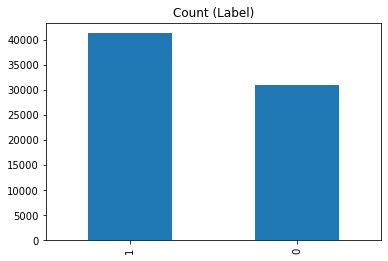

In [6]:
# Plotting a bar graph with the number of Legitimate and Phishing class urls

target_count = phishing_raw_df.label.value_counts()
print('Class Legitimate URL:', target_count[0])
print('Class Phishing URL:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

phishing_raw_df.label.value_counts().plot(kind='bar', title='Count (Label)');

Random under-sampling:
1    31025
0    31025
Name: label, dtype: int64


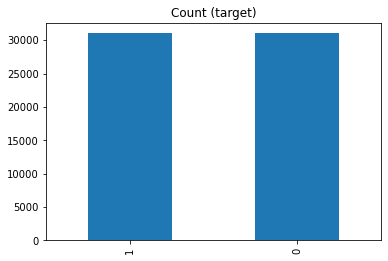

In [7]:
# Each Class count

count_class_1, count_class_0 = phishing_raw_df.label.value_counts()

# Divide by each class

df_class_0 = phishing_raw_df[phishing_raw_df['label'] == 0]
df_class_1 = phishing_raw_df[phishing_raw_df['label'] == 1]

# As the class 1 values are more than to class 0,
# Undersampling is performed to avoid bias and have same number of urls in both classes

df_class_1_under = df_class_1.sample(count_class_0)
phishing_raw_df = pd.concat([df_class_1_under, df_class_0], axis=0)

print('Random under-sampling:')
print(phishing_raw_df.label.value_counts())

phishing_raw_df.label.value_counts().plot(kind='bar', title='Count (target)');

In [8]:
# Viewing sample data from dataframe

phishing_raw_df.head()

,domain,ranking,isIp,valid,activeDuration,urlLen,is@,isredirect,haveDash,domainLen,nosOfSubdomain,label
11838,www.tayarutashdod.co.il/test/wp-content/P!CsO/...,10000000,0,0,0,222,0,0,0,23,3,1
7756,centrocommercialeilporto.it/cgi.bin/paypal.us/...,10000000,0,1,4748,72,0,0,0,27,1,1
48668,9d345009-a-62cb3a1a-s-sites.googlegroups.com/s...,4570,0,1,6939,369,0,0,1,44,2,1
30813,devjaman.com/del,10000000,0,0,0,16,0,0,0,12,1,1
5331,us.battle.net.blizzard.pandaria.en-hxml.net/lo...,10000000,0,0,0,123,0,1,1,43,6,1


## Data Transformation

In [9]:
# Object created for the features class imported from feature_extract file
# This class has the methods that extracts features given the URL

feature = FeatureExtract()

In [10]:
# Insert a new column to the dataframe which shows if 'http' is found in the domain part of the URL.

phishing_raw_df["Domain_http"] = phishing_raw_df["domain"].apply( lambda x: feature.httpDomain(x))

# Insert a new column to the dataframe indicating the length of the URL.

phishing_raw_df["LongURL"] = phishing_raw_df["domain"].apply( lambda x: feature.LongURL(x))

# Insert a new column to the dataframe indicating if the URL belongs to any of the shortening services.

phishing_raw_df["TinyURL"] = phishing_raw_df["domain"].apply( lambda x: feature.tinyURL(x))

# Alter the values in 'nosOfSubdomain' column of the dataframe.
# If the number of sub domains is more than 1, then it is a phishing site.

phishing_raw_df["nosOfSubdomain"] = phishing_raw_df["domain"].apply( lambda x: feature.no_sub_domain(x))

# Alter the values in 'activeDuration' column of the dataframe.
# If the value is greater than 365 (1 year), then it is a legitimate site.

phishing_raw_df["activeDuration"] = phishing_raw_df["activeDuration"].apply( lambda x: 1 if x <= 365 else 0)

# Alter the values in the dataframe column 'ranking'
# If the value is greater than 100000, then it is a phishing site

phishing_raw_df["ranking"] = phishing_raw_df["ranking"].apply( lambda x: 0 if x < 100000 else 1)

# Remove the unwanted columns from the dataframe

phishing_raw_df.drop(['urlLen','domainLen','domain'], inplace=True,axis=1)

# Reorder and rename the columns in the dataframe

Columns = ['Rank','isIP','isValid','Domain_reg_len','is@','isRedirect','haveDash','SubDomain','Label','Domain_http','LongURL','TinyURL']
new_columns = ['Rank','isIP','isValid','Domain_reg_len','is@','isRedirect','haveDash','SubDomain','Domain_http','LongURL','TinyURL','Label']
phishing_raw_df.columns = Columns
phishing_raw_df = phishing_raw_df.reindex(columns=new_columns)
phishing_raw_df1 = phishing_raw_df.copy(deep=True)
phishing_raw_df1.drop(['Domain_http'],inplace=True,axis=1)

# Shuffle the rows in the dataset so that when splitting the train and test set are equally distributed

phishing_raw_df = phishing_raw_df.sample(frac=1).reset_index(drop=True)

# Save the dataframe to a csv file 

phishing_raw_df.to_csv('phishing_feature_engg.csv', encoding='utf-8')

#Display the dataset after data pre-processing

phishing_raw_df.head()

,Rank,isIP,isValid,Domain_reg_len,is@,isRedirect,haveDash,SubDomain,Domain_http,LongURL,TinyURL,Label
0,0,0,0,1,0,0,0,1,0,1,0,0
1,1,0,0,1,0,0,0,1,0,1,0,1
2,1,0,1,0,0,0,0,1,0,1,0,1
3,1,0,1,0,0,0,0,1,0,0,0,0
4,1,0,1,0,0,0,0,1,0,0,0,1


In [11]:
# Check for null values

phishing_raw_df.isnull().sum()

Rank              0
isIP              0
isValid           0
Domain_reg_len    0
is@               0
isRedirect        0
haveDash          0
SubDomain         0
Domain_http       0
LongURL           0
TinyURL           0
Label             0
dtype: int64

## Data Statistics

In [12]:
phishing_raw_df.describe()

,Rank,isIP,isValid,Domain_reg_len,is@,isRedirect,haveDash,SubDomain,Domain_http,LongURL,TinyURL,Label
count,62050.000000,62050.000000,62050.000000,62050.000000,62050.000000,62050.000000,62050.000000,62050.000000,62050.0,62050.000000,62050.000000,62050.000000
mean,0.663417,0.000177,0.593135,0.412055,0.002353,0.006382,0.143449,0.549621,0.0,0.353312,0.069718,0.500000
std,0.472545,0.013313,0.491253,0.492209,0.048450,0.079632,0.350533,0.497536,0.0,0.478002,0.254673,0.500004
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.500000
75%,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.0,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000


In [13]:
# Heat Map

#plt.figure(figsize=(15,7))
#sns.heatmap(phishing_raw_df1.corr(),annot=True, linewidth=0.5)

In [14]:
# Label column was dropped and stored the feature data in X
X=phishing_raw_df.drop(["Label"],axis=1)

# store the labels in y
Y=phishing_raw_df["Label"]

#split the data
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=101)

In [15]:
# Fit the data with decision tree classifier to identify feature importance

dtc = DecisionTreeClassifier(criterion = "entropy", random_state = 100,max_depth = 5)
dtc.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=100)

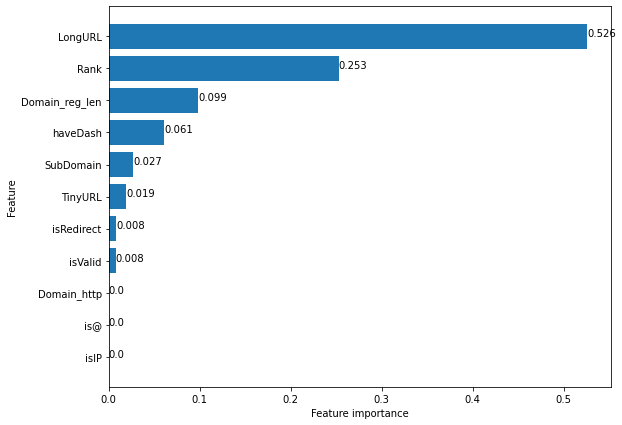

In [16]:
# Get the feature importance for all the features, from the decision tree classifier

importances = dtc.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(9,7))
n_features = X_train.shape[1]
plt.barh(range(n_features), importances[indices], align='center')
plt.yticks(np.arange(n_features), X_train.columns[indices])
for index, value in enumerate(importances[indices]):
    plt.text(value, index, str(round(value,3)))
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.show()


In [17]:
# Drop the features with least importance and assign the input and output
# variables from the dataset

phishing_raw_df.drop(["isIP","Domain_http","is@"],inplace=True,axis=1)
X = phishing_raw_df.iloc[:, :8]
Y = phishing_raw_df["Label"]

In [18]:
# Split the data for training and testing 

X_train, X_test, y_train, y_test = train_test_split(X.values,Y.values, test_size=0.3, random_state=101)

## Model Development

### XGBoost

In [19]:
def XG_Boost_classifier():
    
    # Funtion for XGBoost model
    
    global XGB_model
    
    XGB_model = XGBClassifier(random_state=100)
    
    train_start = timeit.default_timer()
    XGB_model.fit(X_train, y_train)
    train_time = timeit.default_timer() - train_start
    
    test_start = timeit.default_timer()
    pred_XGB_test = XGB_model.predict(X_test)
    test_time = timeit.default_timer() - test_start
    
    pred_XGB_train = XGB_model.predict(X_train)
    kappa_XGB = cohen_kappa_score(y_test, pred_XGB_test)
    
    # Print the classification report

    print('\n---------- XGBoost ----------\n')
    print('Classification Report:\n', classification_report(y_test, pred_XGB_test, target_names=['0','1']))
    
    # Print the Confusion matrix
    
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred_XGB_test),display_labels=['0','1'])
    print('\nConfusion matrix:\n',disp.plot())
    
    # Print the precision-recall graph
    
    plot_precision_recall_curve(XGB_model, X_test, y_test, name = 'XGBoost')
    
    return (('XGBoost',accuracy_score(y_train,pred_XGB_train),accuracy_score(y_test,pred_XGB_test),kappa_XGB, train_time,test_time))


## Decision Tree

In [20]:
def Decision_Tree_classifier():
    
    # Funtion for Decision Tree model
    
    global DTC_model
    
    DTC_model = DecisionTreeClassifier(criterion = "entropy", random_state = 100,max_depth = 5)
    
    train_start = timeit.default_timer()
    DTC_model.fit(X_train,y_train)
    train_time = timeit.default_timer() - train_start
    
    test_start = timeit.default_timer()
    pred_dtc_test = DTC_model.predict(X_test)
    test_time = timeit.default_timer() - test_start
    
    pred_dtc_train = DTC_model.predict(X_train)
    kappa_dtc = cohen_kappa_score(y_test, pred_dtc_test)
    
    # Print the classification report
    
    print('\n---------- Decision Tree ----------\n')
    print('Classification Report :\n', classification_report(y_test, pred_dtc_test, target_names=['0','1']))
    
    # Print the Confusion matrix
    
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred_dtc_test),display_labels=['0','1'])
    print('\nConfusion matrix:\n',disp.plot())
    
    # Print the precision-recall graph
    
    plot_precision_recall_curve(DTC_model, X_test, y_test, name = 'Decision Tree')
    
    return (('Decision Tree',accuracy_score(y_train,pred_dtc_train),accuracy_score(y_test,pred_dtc_test), kappa_dtc, train_time,test_time))

## Neural Network

In [21]:
def Neural_Network_classifier():
    
    # Funtion for Neural Network model
    # The neural network is trained with 3 layers 
    global MLP_model

    MLP_model = MLPClassifier(hidden_layer_sizes=(12,12,12), activation='relu', solver='adam', max_iter=500)
    
    train_start = timeit.default_timer()  
    MLP_model.fit(X_train,y_train)
    train_time = timeit.default_timer() - train_start
    
    test_start = timeit.default_timer()
    pred_NN_test = MLP_model.predict(X_test)
    test_time = timeit.default_timer() - test_start
    
    pred_NN_train = MLP_model.predict(X_train)
    kappa_NN = cohen_kappa_score(y_test, pred_NN_test)
    
    # Print the classification report
    
    print('\n---------- Neural Network ----------\n')
    print('Classification Report:\n', classification_report(y_test, pred_NN_test, target_names=['0','1']))
    
    # Print the Confusion matrix
    
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred_NN_test),display_labels=['0','1'])
    print('\nconfusion matrix:\n',disp.plot())
    
    # Print the precision-recall graph
    
    plot_precision_recall_curve(MLP_model, X_test, y_test, name = 'Neural Network')
    
    return (('Neural Network',accuracy_score(y_train,pred_NN_train),accuracy_score(y_test,pred_NN_test), kappa_NN, train_time,test_time))

# SVM

In [22]:
def Svm_classifier():
    
    # Funtion for SVM model
    
    global SVM_model
    
    SVM_model = SVC(kernel='poly', degree=9, random_state=12)
    
    train_start = timeit.default_timer()
    SVM_model.fit(X_train, y_train)
    train_time = timeit.default_timer() - train_start
    
    test_start = timeit.default_timer()
    pred_svm_test = SVM_model.predict(X_test)
    test_time = timeit.default_timer() - test_start
    
    pred_svm_train = SVM_model.predict(X_train)
    kappa_svm = cohen_kappa_score(y_test, pred_svm_test)
    
    # Print the classification report
    
    print('\n---------- SVM ----------\n')
    print('Classification Report:\n', classification_report(y_test, pred_svm_test, target_names=['0','1']))
    
    # Print the Confusion matrix
    
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred_svm_test),display_labels=['0','1'])
    print('\nconfusion matrix:\n',disp.plot())
    
    # Print the precision-recall graph
    
    plot_precision_recall_curve(SVM_model, X_test, y_test, name = 'SVM')
    
    return (('SVM',accuracy_score(y_train,pred_svm_train),accuracy_score(y_test,pred_svm_test), kappa_svm, train_time,test_time))

# Naive Bayes

In [23]:
def Naive_Bayes_classifier():
    
    # Funtion for Naive Bayes model
    
    global NBC_model
    
    NBC_model = BernoulliNB()
    
    train_start = timeit.default_timer()
    NBC_model.fit(X_train,y_train)
    train_time = timeit.default_timer() - train_start
    
    test_start = timeit.default_timer()
    pred_nb_test = NBC_model.predict(X_test)
    test_time = timeit.default_timer() - test_start
    
    pred_nb_train = NBC_model.predict(X_train)
    kappa_nb = cohen_kappa_score(y_test, pred_nb_test)
    
    # Print the classification report
    
    print('\n---------- Naive Bayes ----------\n')
    print('Classification Report:\n', classification_report(y_test, pred_nb_test, target_names=['0','1']))
    
    # Print the Confusion matrix
    
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred_nb_test),display_labels=['0','1'])
    print('\nconfusion matrix:\n',disp.plot())
    
    # Print the precision-recall graph
    
    plot_precision_recall_curve(NBC_model, X_test, y_test, name = 'Naive Bayes')
    
    return (('Naive Bayes',accuracy_score(y_train,pred_nb_train),accuracy_score(y_test,pred_nb_test),kappa_nb, train_time,test_time))

# Logistic Regression

In [24]:
def Logistic_Regression_classifier():
    
    # Funtion for Logistic Regression model
    
    global LOG_model

    LOG_model = LogisticRegression(random_state=100)
    
    train_start = timeit.default_timer()
    LOG_model.fit(X_train,y_train)
    train_time = timeit.default_timer() - train_start
    
    test_start = timeit.default_timer()
    pred_logreg_test = LOG_model.predict(X_test)
    test_time = timeit.default_timer() - test_start
   
    pred_logreg_train = LOG_model.predict(X_train)
    kappa_lg =  cohen_kappa_score(y_test, pred_logreg_test)
    
    # Print the classification report
    
    print('\n---------- Logistic Regression ----------\n')
    print('Classification Report:\n', classification_report(y_test, pred_logreg_test, target_names=['0','1']))
    
    # Print the Confusion matrix
    
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred_logreg_test),display_labels=['0','1'])
    print('\nconfusion matrix:\n',disp.plot())
    
    # Print the precision-recall graph
    
    plot_precision_recall_curve(LOG_model, X_test, y_test, name = 'Logistic Regression')
    
    return (('Logistic Regression',accuracy_score(y_train,pred_logreg_train),accuracy_score(y_test,pred_logreg_test),kappa_lg, train_time,test_time))

# RandomForest

In [25]:
def Random_Forest_classifier():
    
    # Funtion for Random Forest model
    
    global RFC_model
    
    RFC_model = RandomForestClassifier(criterion='entropy',random_state=100)
    
    train_start = timeit.default_timer()
    RFC_model.fit(X_train, y_train)
    train_time = timeit.default_timer() - train_start
    
    test_start = timeit.default_timer()
    pred_RF_test = RFC_model.predict(X_test)
    test_time = timeit.default_timer() - test_start
    
    pred_RF_train = RFC_model.predict(X_train)
    kappa_rf = cohen_kappa_score(y_test, pred_RF_test)
    
    # Print the classification report
    
    print('\n---------- Random Forest ----------\n')
    print('Classification Report:\n', classification_report(y_test, pred_RF_test, target_names=['0','1']))
    
    # Print the Confusion matrix
    
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred_RF_test),display_labels=['0','1'])
    print('\nconfusion matrix:\n',disp.plot())
    
    # Print the precision-recall graph
    
    plot_precision_recall_curve(RFC_model, X_test, y_test, name = 'Random Forest')
    
    return (('Random Forest',accuracy_score(y_train,pred_RF_train),accuracy_score(y_test,pred_RF_test),kappa_rf, train_time, test_time))

## Evaluation Metrics

In [26]:

def Roc_curves():
    
    # Function to display the ROC curves for the models
    plt.figure()
    
    # Add the models to the list that you want to view on the ROC plot
    models = [
    {
        'label': 'Logistic Regression',
        'model': LogisticRegression(random_state=100),
    },
    {
        'label': 'SVM',
        'model': SVC(kernel='linear', C=1.0, random_state=100,probability=True),
    },
    {
        'label': 'NaiveBayes',
        'model': BernoulliNB(),
    },
    {
        'label': 'Decision Tree',
        'model': DecisionTreeClassifier(criterion = "entropy", random_state = 100,max_depth = 5),
    },
    {
        'label': 'RandomForest',
        'model': RandomForestClassifier(criterion='entropy',random_state=100)
    },
    {
        'label': 'XGBoost',
        'model': XGBClassifier(random_state=100),
    },
    {
        'label': 'Neural Network',
        'model': MLPClassifier(hidden_layer_sizes=(12,12,12), activation='relu', solver='adam', max_iter=500)
    }
    ]

    # Below for loop iterates through your models list
    
    for m in models: 
        model = m['model']                # select the model
        model.fit(X_train, y_train)       # train the model
        y_pred=model.predict(X_test)      # predict the test data
    
    # Compute False postive rate, and True positive rate
    
        fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
    
    # Calculate Area under the curve to display on the plot
    
        auc = metrics.roc_auc_score(y_test,model.predict(X_test))
    # Now, plot the computed values
    
        plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
        
    # Custom settings for the plot 
    
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity(False Positive Rate)')
    plt.ylabel('Sensitivity(True Positive Rate)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()   

In [27]:
def call_ml_models():
    
    # Function to invoke all the proposed ML models and consolidates the performace of each model
    
    kappa_list = []
    ML_Model = []
    acc_train = []
    acc_test = []
    train_time = []
    test_time = []
    model_list = [Logistic_Regression_classifier,Naive_Bayes_classifier,Svm_classifier,Decision_Tree_classifier,Random_Forest_classifier,XG_Boost_classifier,Neural_Network_classifier]
    
    # Below loop iterates to invoke each models in the model_list
    
    for model in model_list: 
        res = model()
        ML_Model.append(res[0])
        acc_train.append(res[1])
        acc_test.append(res[2])
        kappa_list.append(res[3]) 
        train_time.append(res[4])
        test_time.append(res[5])
        
    # Call to display the ROC curves of all the models
    
    Roc_curves()
        
    return ML_Model,acc_train,acc_test,kappa_list,train_time,test_time  




---------- Logistic Regression ----------

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80      9320
           1       0.80      0.80      0.80      9295

    accuracy                           0.80     18615
   macro avg       0.80      0.80      0.80     18615
weighted avg       0.80      0.80      0.80     18615


confusion matrix:

---------- Naive Bayes ----------

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.81      0.81      9320
           1       0.81      0.80      0.80      9295

    accuracy                           0.80     18615
   macro avg       0.80      0.80      0.80     18615
weighted avg       0.80      0.80      0.80     18615



C:\Users\contactkrishraj\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\contactkrishraj\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)



confusion matrix:

---------- SVM ----------

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.86      0.83      9320
           1       0.84      0.79      0.82      9295

    accuracy                           0.82     18615
   macro avg       0.83      0.82      0.82     18615
weighted avg       0.82      0.82      0.82     18615


confusion matrix:


C:\Users\contactkrishraj\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)



---------- Decision Tree ----------

Classification Report :
               precision    recall  f1-score   support

           0       0.81      0.85      0.83      9320
           1       0.84      0.80      0.82      9295

    accuracy                           0.82     18615
   macro avg       0.82      0.82      0.82     18615
weighted avg       0.82      0.82      0.82     18615


Confusion matrix:


C:\Users\contactkrishraj\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)



---------- Random Forest ----------

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.86      0.83      9320
           1       0.85      0.79      0.82      9295

    accuracy                           0.82     18615
   macro avg       0.83      0.82      0.82     18615
weighted avg       0.83      0.82      0.82     18615


confusion matrix:


C:\Users\contactkrishraj\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)



---------- XGBoost ----------

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.86      0.83      9320
           1       0.85      0.79      0.82      9295

    accuracy                           0.82     18615
   macro avg       0.83      0.82      0.82     18615
weighted avg       0.83      0.82      0.82     18615


Confusion matrix:


C:\Users\contactkrishraj\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)



---------- Neural Network ----------

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.85      0.83      9320
           1       0.84      0.79      0.82      9295

    accuracy                           0.82     18615
   macro avg       0.82      0.82      0.82     18615
weighted avg       0.82      0.82      0.82     18615


confusion matrix:


C:\Users\contactkrishraj\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


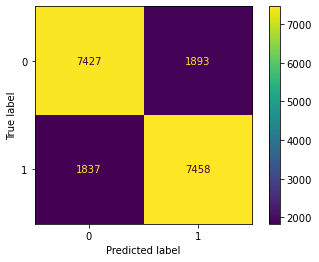

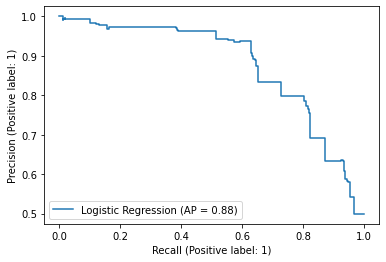

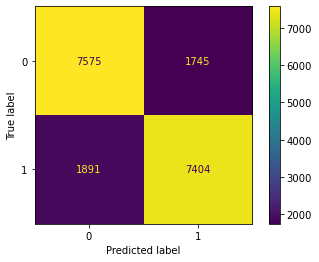

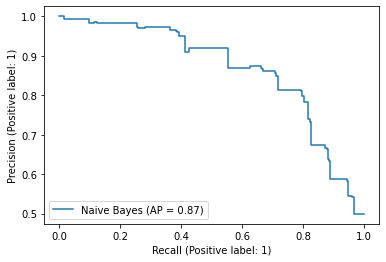

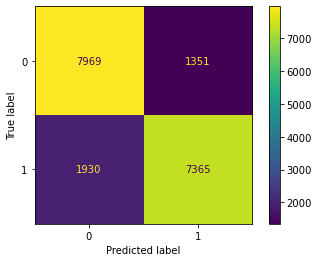

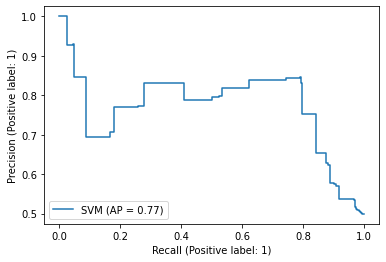

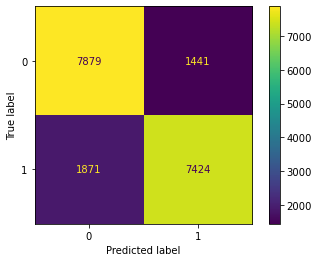

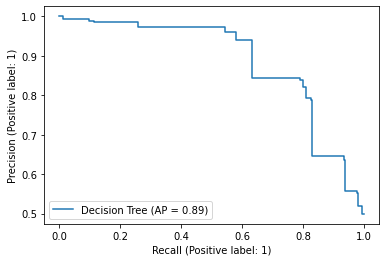

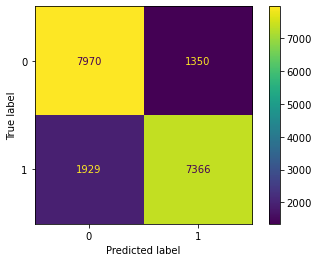

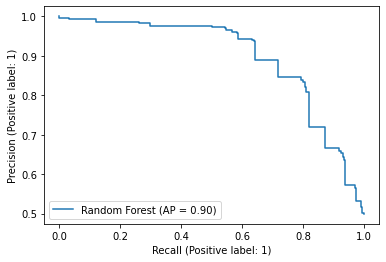

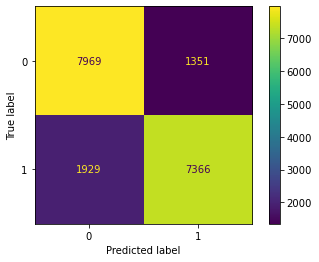

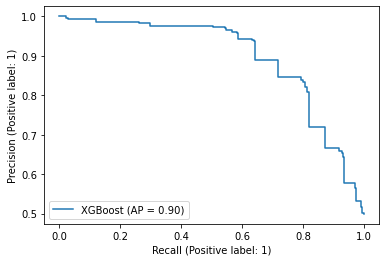

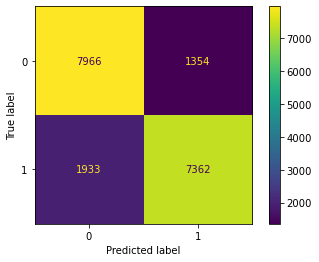

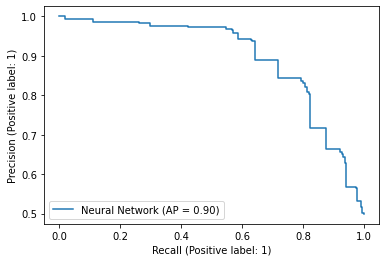

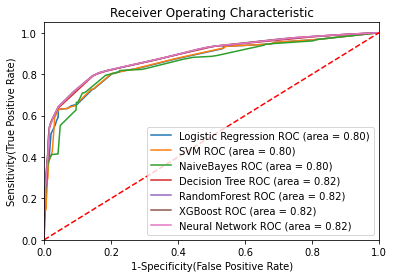

,ML Model,Train Accuracy,Test Accuracy,Kappa Score,Training Time,Testing Time
0,Logistic Regression,0.797951,0.799624,0.599250,0.082051,0.001416
1,Naive Bayes,0.800276,0.804674,0.609338,0.011060,0.002865
2,SVM,0.820905,0.823744,0.647458,19.673857,6.207087
3,Decision Tree,0.819616,0.822079,0.644135,0.011152,0.001032
4,Random Forest,0.820905,0.823852,0.647673,0.695406,0.118456
5,XGBoost,0.820905,0.823798,0.647566,0.438322,0.007029
6,Neural Network,0.820490,0.823422,0.646814,5.381887,0.004250


In [28]:
# Invoke the call models function to display the model performance statistics

ML_Model,acc_train,acc_test,kappa_list,train_time,test_time = call_ml_models()

# Create the dataframe with the consolidated accuracies and timings of all models

results = pd.DataFrame({ 'ML Model': ML_Model, 
    'Train Accuracy': acc_train,
    'Test Accuracy': acc_test, 'Kappa Score': kappa_list,
    'Training Time': train_time, 'Testing Time': test_time})

results # Display results

## Hyper parameter tunning

In [29]:
# Assign the XGBoost parameters to the parameter grid 

param_grid = [
  {
    'n_estimators': [200, 500],
    'max_depth': [3, 4, 5]
  }
]

scoring = {'AUC':'roc_auc', 'Accuracy':make_scorer(accuracy_score)}

In [30]:
# Using Grid search to find the hyper parameters of XGBoost

XGB_grid = GridSearchCV(XGB_model,param_grid=param_grid,cv=5,scoring=scoring,refit='AUC',verbose=1,n_jobs=-1)
XGB_grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012, max_bin=256,
                                     max_ca...,
                                     max_depth=6, max_leaves=0,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1, predictor='auto',
                                     random_state=100, reg_alpha=0,
                                     reg_lambda=1, ...),
             n_jobs=-1,
             param_grid=[{'max_depth': [3, 4, 5], 'n_estimators': [200, 500]}],
             refit='AUC',
             scoring={'AUC': 'roc_auc',
                      'Accuracy': make_scorer(accuracy_score)},
             verbose=1)

In [31]:
# Check for accuracy changes using the fine tuned XGB Model parameters 
XGB_model_best = XGB_grid.best_estimator_

XGB_model_best.fit(X_train, y_train)
pred_RF_test = XGB_model_best.predict(X_test)
pred_RF_train = XGB_model_best.predict(X_train)

kappa_rf = cohen_kappa_score(y_test, pred_RF_test)
train_acc = accuracy_score(y_train,pred_RF_train)
test_acc = accuracy_score(y_test,pred_RF_test)

print('Kappa: ',kappa_rf)
print('Train accuracy: ',train_acc)
print('Test accuracy: ',test_acc)

Kappa:  0.6476733942078623
Train accuracy:  0.8209048002762749
Test accuracy:  0.8238517324738115


## Save the model

In [32]:
def save_model(model):
    
    # Function to save the required model using pickle
    
    with open('phishing_classifier.pkl', 'wb') as f:
        pickle.dump(model, f, -1)
        f.close()


        
save_model(XGB_model_best)

## Perform the classification using the saved model

In [33]:
classification = PredictURL()

In [34]:
%%time
#classification.predict('https://www.sjsu.okta.com')
#classification.predict('sjsu.com')

CPU times: total: 0 ns
Wall time: 0 ns
